In [1]:
# Cell 1: Import thư viện (Thêm vào các import hiện có)
%pip install -q ipympl
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib widget
import time # Thêm time để dùng cho client_id nếu cần (đã có trong agv_mqtt.py)

# >>> THÊM DÒNG SAU:
from agv_mqtt import AGVMQTTClient # Giả sử file agv_mqtt.py cùng thư mục

# ... (Các cell đọc dữ liệu và tạo đồ thị G, pos giữ nguyên) ...
# Cell 2: Đọc dữ liệu
# Đọc ma trận kề từ file CSV
distance_matrix = pd.read_csv("map-connection-and-distance.csv", header=None).values
print(f"Đã đọc thành công file với kích thước: {distance_matrix.shape}")



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Đã đọc thành công file với kích thước: (32, 32)


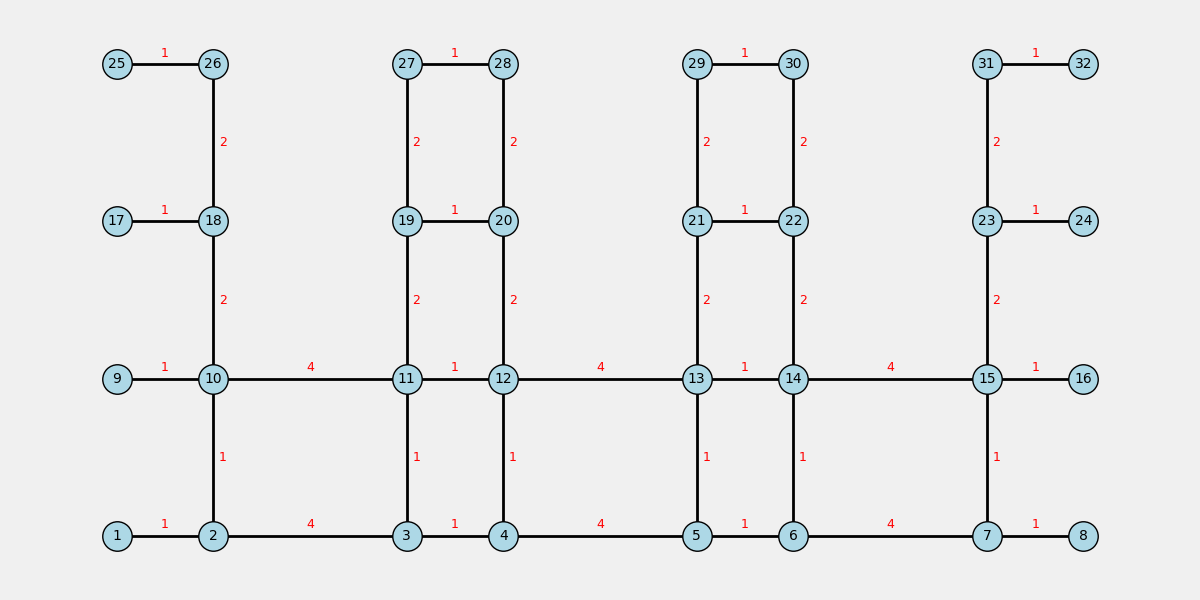

In [2]:
# Cell 3: Tạo đồ thị
# Cell 3: Tạo và hiển thị đồ thị
# Khởi tạo đồ thị
G = nx.Graph()

# Thêm các node (đánh số từ 1-32)
for i in range(distance_matrix.shape[0]):
    G.add_node(i+1)

# Thêm các cạnh với trọng số từ ma trận kề
for i in range(distance_matrix.shape[0]):
    for j in range(distance_matrix.shape[1]):
        if distance_matrix[i][j] != 10000 and i != j:  # Nếu có kết nối
            G.add_edge(i+1, j+1, weight=distance_matrix[i][j])

# Tạo figure với kích thước phù hợp
plt.figure(figsize=(12, 6), facecolor='#F0F0F0')

# Định nghĩa vị trí của các node theo grid 
# Các khoảng cách được đặt để thể hiện trọng số cạnh
pos = {}
cols = [0, 1, 3, 4, 6, 7, 9, 10]  # Vị trí các cột (tạo khoảng cách giữa cột 1-2, 3-4, etc nhỏ hơn)

for row in range(4):
    for i, col in enumerate(cols):
        node_num = row * 8 + i + 1
        pos[node_num] = (col, row)

# Vẽ các node
nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                      node_size=450, edgecolors='black')

# Vẽ nhãn của node
nx.draw_networkx_labels(G, pos, font_size=10)

# Vẽ các cạnh
nx.draw_networkx_edges(G, pos, width=2, edge_color='black')

# Vẽ nhãn trọng số
for u, v, data in G.edges(data=True):
    x1, y1 = pos[u]
    x2, y2 = pos[v]
    x = (x1 + x2) / 2
    y = (y1 + y2) / 2
    
    # Điều chỉnh vị trí nhãn lên trên cạnh
    if abs(x2 - x1) > abs(y2 - y1):  # Cạnh ngang
        y += 0.07
    else:  # Cạnh dọc
        if y2 > y1:  # Từ dưới lên
            x += 0.1
        else:  # Từ trên xuống
            x += 0.1
    
    plt.text(x, y, data['weight'], color='red', fontsize=9, ha='center', va='center')

plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Cell mới: Định nghĩa và chạy animate_cars
import matplotlib.animation as animation
import ipywidgets as widgets
from IPython.display import display, clear_output
from agv_mqtt import AGVMQTTClient # Đảm bảo bạn đã import AGVMQTTClient
import matplotlib.pyplot as plt # Thêm import này nếu chưa có
import networkx as nx # Thêm import này nếu chưa có

# Giả sử G (đồ thị) và pos (vị trí node) đã được định nghĩa ở các cell trước.
# Nếu chưa, bạn cần khởi tạo chúng. Ví dụ:
# G = nx.Graph()
# pos = {}
# ... (code tạo đồ thị và vị trí node của bạn) ...

def animate_cars(G_graph, pos_dict, initial_car_setup_list=None):
    MQTT_BROKER = "localhost" # Change to your MQTT broker address
    MQTT_PORT = 1883 # Change to your MQTT broker port
    agv_mqtt_clients = {}

    if initial_car_setup_list is None:
        initial_car_setup_list = [
            {'id': 1, 'start_node': 7, 'color': 'red'},
            {'id': 2, 'start_node': 17, 'color': 'blue'},
            {'id': 3, 'start_node': 32, 'color': 'green'}
        ]

    fig_anim, ax_anim = plt.subplots(figsize=(12, 6), facecolor='#F0F0F0')

    nx.draw_networkx_nodes(G_graph, pos_dict, node_color='lightblue', node_size=450, edgecolors='black', ax=ax_anim)
    nx.draw_networkx_labels(G_graph, pos_dict, font_size=10, ax=ax_anim)
    nx.draw_networkx_edges(G_graph, pos_dict, width=2, edge_color='black', ax=ax_anim)
    for u_edge, v_edge, data_edge in G_graph.edges(data=True):
        x1_e, y1_e = pos_dict[u_edge]; x2_e, y2_e = pos_dict[v_edge]
        x_mid_e, y_mid_e = (x1_e + x2_e) / 2, (y1_e + y2_e) / 2
        if abs(x2_e - x1_e) > abs(y2_e - y1_e): y_mid_e += 0.07
        else: x_mid_e += 0.1
        ax_anim.text(x_mid_e, y_mid_e, data_edge['weight'], color='red', fontsize=9, ha='center', va='center')

    agv_data_sim = {}
    animation_is_globally_paused_sim = [False]
    status_text_sim = ax_anim.text(0.02, 0.98, "ALL AGVs IDLE (Waiting for server commands)",
                                 transform=ax_anim.transAxes, fontsize=12, ha='left', va='top',
                                 bbox=dict(facecolor='white', alpha=0.7))

    anim_obj_ref = [] # Sử dụng list để truyền tham chiếu của anim_obj

    def handle_command_from_controller(agv_id_received, received_next_node, full_command_payload):
        # nonlocal anim_obj # Không cần nonlocal nếu dùng list để tham chiếu
        print(f"[SIM CALLBACK] AGV {agv_id_received}: Received command. Payload: {full_command_payload}")

        agv_info = agv_data_sim.get(agv_id_received)
        if not agv_info:
            print(f"Error: AGV ID {agv_id_received} not in simulator.")
            return

        motion_state = full_command_payload.get("motion_state")
        current_node_of_agv = agv_info['current_node'] # Lấy node hiện tại TRƯỚC khi xử lý

        if motion_state == 1: # MOVING
            if agv_info['is_moving']:
                print(f"Info: AGV {agv_id_received} is already moving. New command to node {received_next_node} (from payload) ignored.")
                return

            if received_next_node is None or received_next_node == 0:
                agv_info['notification_widget'].set_text(f"Car {agv_id_received}: MOVING state but invalid next_node ({received_next_node}).")
                print(f"Error: AGV {agv_id_received} MOVING state but invalid next_node ({received_next_node}) received.")
                # Không publish ở đây, vì trạng thái node không đổi
                return

            if not G_graph.has_edge(current_node_of_agv, received_next_node):
                agv_info['notification_widget'].set_text(f"Car {agv_id_received}: No edge {current_node_of_agv}->{received_next_node} (Server).")
                # Không publish ở đây
                return

            path_segment_coords_local = []
            path_segment_arrivals_local = {}
            anim_frame_count_local_cb = 0
            node1_cb, node2_cb = current_node_of_agv, received_next_node
            weight_cb = G_graph[node1_cb][node2_cb]['weight']
            x1_cb, y1_cb = pos_dict[node1_cb]; x2_cb, y2_cb = pos_dict[node2_cb]
            speed_cb = 0.25
            frames_for_segment_cb = max(1, int(weight_cb / speed_cb if speed_cb > 0 else 1))

            for j_cb in range(frames_for_segment_cb + 1):
                t_cb = j_cb / frames_for_segment_cb if frames_for_segment_cb > 0 else 1.0
                x_cb = x1_cb + t_cb * (x2_cb - x1_cb)
                y_cb = y1_cb + t_cb * (y2_cb - y1_cb)
                path_segment_coords_local.append((x_cb, y_cb))
                if j_cb == frames_for_segment_cb:
                    path_segment_arrivals_local[anim_frame_count_local_cb] = node2_cb
                anim_frame_count_local_cb += 1

            agv_info['path_animation_coords'] = path_segment_coords_local
            agv_info['node_arrival_at_frame'] = path_segment_arrivals_local
            agv_info['current_animation_frame_idx'] = 0
            agv_info['is_moving'] = True
            agv_info['notification_widget'].set_text(f"Car {agv_id_received} ({agv_info['color']}) server cmd -> Node {received_next_node}")
            print(f"[SIM DEBUG] AGV {agv_id_received} set to moving. Path coords count: {len(path_segment_coords_local)}")

        elif motion_state == 0: # IDLE
            was_moving = agv_info['is_moving']
            agv_info['is_moving'] = False
            agv_info['path_animation_coords'] = []
            agv_info['node_arrival_at_frame'] = {}
            agv_info['current_animation_frame_idx'] = 0
            agv_info['notification_widget'].set_text(f"Car {agv_id_received} ({agv_info['color']}) set to IDLE at Node {agv_info['current_node']}.")
            print(f"[SIM DEBUG] AGV {agv_id_received} set to IDLE at node {agv_info['current_node']}.")
            # Chỉ publish nếu nó vừa dừng từ trạng thái MOVING (để xác nhận đã dừng)
            # Hoặc nếu bạn có logic cụ thể yêu cầu AGV phải báo cáo lại khi nhận lệnh IDLE.
            # Hiện tại, `init_animation_func` và `update_animation_func` (khi đến node) đã đủ.
            # if was_moving: # Nếu cần xác nhận dừng
            #    if agv_id_received in agv_mqtt_clients:
            #        agv_mqtt_clients[agv_id_received].publish_current_node(agv_info['current_node'])


        elif motion_state == 2: # WAITING
            was_moving = agv_info['is_moving']
            agv_info['is_moving'] = False
            agv_info['path_animation_coords'] = []
            agv_info['node_arrival_at_frame'] = {}
            agv_info['current_animation_frame_idx'] = 0
            agv_info['notification_widget'].set_text(f"Car {agv_id_received} ({agv_info['color']}) set to WAITING at Node {agv_info['current_node']}.")
            print(f"[SIM DEBUG] AGV {agv_id_received} set to WAITING at node {agv_info['current_node']}.")
            # Tương tự IDLE, việc publish ở đây có thể không cần thiết.

        else:
            print(f"Error: AGV {agv_id_received} received unhandled or missing motion_state in payload: {full_command_payload}")
            return

        should_resume_animation = (motion_state == 1 and agv_info['is_moving'])
        if should_resume_animation:
            if status_text_sim.get_text().startswith("ALL AGVs IDLE"):
                 status_text_sim.set_text("RUNNING (AGV receiving commands)")
            if animation_is_globally_paused_sim[0] and anim_obj_ref: # Kiểm tra anim_obj_ref có phần tử không
                _anim_obj = anim_obj_ref[0]
                print(f"[SIM DEBUG] Animation was globally paused. Resuming for AGV {agv_id_received} to move.")
                animation_is_globally_paused_sim[0] = False
                if hasattr(_anim_obj, 'resume'): _anim_obj.resume()
                elif hasattr(_anim_obj, 'event_source') and _anim_obj.event_source is not None: _anim_obj.event_source.start()

    for car_config_item in initial_car_setup_list:
        agv_id_val = car_config_item['id']
        start_node_val = car_config_item['start_node']
        color_val = car_config_item['color']

        if start_node_val not in G_graph:
            print(f"Warning: Start node {start_node_val} for AGV {agv_id_val} not in graph. Skipping AGV.")
            continue

        marker, = ax_anim.plot([], [], 'o', markersize=15, color=color_val, markeredgecolor='black')
        notification = ax_anim.text(0.02, 0.15 + (agv_id_val -1)*0.05, "",
                                  transform=ax_anim.transAxes, fontsize=10, ha='left', va='bottom',
                                  bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))

        agv_data_sim[agv_id_val] = {
            'marker_obj': marker, 'color': color_val, 'current_node': start_node_val,
            'path_animation_coords': [], 'node_arrival_at_frame': {},
            'current_animation_frame_idx': 0, 'is_moving': False,
            'notification_widget': notification,
            'has_published_initial_state': False # Thêm cờ này
        }

        client_instance = AGVMQTTClient(MQTT_BROKER, MQTT_PORT, agv_id_val, initial_node=start_node_val)
        client_instance.connect()
        client_instance.set_new_route_callback(handle_command_from_controller)
        agv_mqtt_clients[agv_id_val] = client_instance

    def toggle_global_pause(event):
        # nonlocal anim_obj # Không cần nonlocal nếu dùng list để tham chiếu
        if not anim_obj_ref: return # Không làm gì nếu anim_obj chưa được tạo
        _anim_obj = anim_obj_ref[0]

        animation_is_globally_paused_sim[0] = not animation_is_globally_paused_sim[0]
        if animation_is_globally_paused_sim[0]:
            if hasattr(_anim_obj, 'pause'): _anim_obj.pause()
            elif hasattr(_anim_obj, 'event_source') and _anim_obj.event_source is not None : _anim_obj.event_source.stop()
            status_text_sim.set_text("PAUSED (Click to resume all)")
        else:
            if hasattr(_anim_obj, 'resume'): _anim_obj.resume()
            elif hasattr(_anim_obj, 'event_source') and _anim_obj.event_source is not None : _anim_obj.event_source.start()
            if not any(d['is_moving'] for d in agv_data_sim.values()):
                 status_text_sim.set_text("ALL AGVs IDLE (Waiting for server commands)")
            else:
                 status_text_sim.set_text("RUNNING (AGV receiving commands)")
    fig_anim.canvas.mpl_connect('button_press_event', toggle_global_pause)

    def init_animation_func():
        blit_items_init = []
        for agv_id_init_val, data_init_val in agv_data_sim.items():
            start_node_init_val = data_init_val['current_node']
            x_init_val, y_init_val = pos_dict[start_node_init_val]
            data_init_val['marker_obj'].set_data([x_init_val], [y_init_val])
            data_init_val['notification_widget'].set_text(f"Car {agv_id_init_val} ({data_init_val['color']}) at Node {start_node_init_val}. Waiting server.")
            if agv_id_init_val in agv_mqtt_clients and not data_init_val['has_published_initial_state']:
                print(f"[SIM INIT] AGV {agv_id_init_val} publishing initial node {start_node_init_val}")
                agv_mqtt_clients[agv_id_init_val].publish_current_node(start_node_init_val)
                data_init_val['has_published_initial_state'] = True # Đánh dấu đã publish
            blit_items_init.append(data_init_val['marker_obj'])
            blit_items_init.append(data_init_val['notification_widget'])
        blit_items_init.append(status_text_sim)
        return blit_items_init

    def update_animation_func(frame_num):
        if animation_is_globally_paused_sim[0]:
             return [d['marker_obj'] for d in agv_data_sim.values()] + \
                    [d['notification_widget'] for d in agv_data_sim.values()] + \
                    [status_text_sim]

        at_least_one_car_is_active_in_frame = False
        for agv_id_upd, agv_curr_data in agv_data_sim.items():
            if not agv_curr_data['is_moving']:
                continue

            at_least_one_car_is_active_in_frame = True
            anim_idx = agv_curr_data['current_animation_frame_idx']

            if anim_idx < len(agv_curr_data['path_animation_coords']):
                x_coord_draw, y_coord_draw = agv_curr_data['path_animation_coords'][anim_idx]
                agv_curr_data['marker_obj'].set_data([x_coord_draw], [y_coord_draw])

                if anim_idx in agv_curr_data['node_arrival_at_frame']:
                    node_arrived_val = agv_curr_data['node_arrival_at_frame'][anim_idx]
                    # Chỉ publish nếu node thực sự thay đổi
                    if agv_curr_data['current_node'] != node_arrived_val:
                        agv_curr_data['current_node'] = node_arrived_val
                        print(f"[SIM ANIMATION] AGV {agv_id_upd} arrived & publishing NEW node {node_arrived_val}")
                        if agv_id_upd in agv_mqtt_clients:
                            agv_mqtt_clients[agv_id_upd].publish_current_node(node_arrived_val)
                    else: # Đã ở node đó rồi (có thể do frame cuối cùng của segment trước đó)
                        print(f"[SIM ANIMATION] AGV {agv_id_upd} re-confirmed at node {node_arrived_val}, not re-publishing.")


                    agv_curr_data['is_moving'] = False
                    agv_curr_data['path_animation_coords'] = []
                    agv_curr_data['node_arrival_at_frame'] = {}
                    agv_curr_data['notification_widget'].set_text(
                        f"Car {agv_id_upd} ({agv_curr_data['color']}) arrived at Node {node_arrived_val}. Waiting server."
                    )
                agv_curr_data['current_animation_frame_idx'] += 1
            else:
                if agv_curr_data['is_moving']:
                    agv_curr_data['is_moving'] = False
                    print(f"[SIM DEBUG] AGV {agv_id_upd} path ended/empty, setting is_moving=False at node {agv_curr_data['current_node']}.")
                    agv_curr_data['notification_widget'].set_text(
                         f"Car {agv_id_upd} ({agv_curr_data['color']}) is at Node {agv_curr_data['current_node']}. Waiting server (path ended/empty)."
                    )
                    # Không publish ở đây nữa vì trạng thái node không đổi và đã được xử lý ở trên hoặc init.

        if not animation_is_globally_paused_sim[0]:
            if not any(d['is_moving'] for d in agv_data_sim.values()):
                 status_text_sim.set_text("ALL AGVs IDLE (Waiting for server commands)")
            elif at_least_one_car_is_active_in_frame :
                 status_text_sim.set_text("RUNNING (AGV receiving commands)")

        return [d['marker_obj'] for d in agv_data_sim.values()] + \
               [d['notification_widget'] for d in agv_data_sim.values()] + \
               [status_text_sim]

    # Gán anim_obj cho một list để có thể truy cập từ toggle_global_pause và handle_command_from_controller
    _anim_obj_instance = animation.FuncAnimation(
        fig_anim, update_animation_func, init_func=init_animation_func,
        frames=None, interval=100, blit=True, save_count=500
    )
    anim_obj_ref.append(_anim_obj_instance)


    plt.axis('off')
    plt.tight_layout()

    disconnect_button_widget = widgets.Button(description="Disconnect All MQTT")
    def on_disconnect_btn_clicked(b_event):
        # nonlocal anim_obj # Không cần nonlocal nếu dùng list
        if not anim_obj_ref: return
        _anim_obj = anim_obj_ref[0]

        print("Disconnecting all MQTT clients...")
        for client_id_dc, client in list(agv_mqtt_clients.items()): # Sử dụng list() để tránh lỗi khi thay đổi dict
            if client.client.is_connected():
                 client.disconnect()
        agv_mqtt_clients.clear()
        print("All MQTT clients disconnected.")
        if hasattr(_anim_obj, 'event_source') and _anim_obj.event_source is not None:
             _anim_obj.event_source.stop()
        status_text_sim.set_text("MQTT DISCONNECTED - ANIMATION STOPPED")
        disconnect_button_widget.disabled = True
    disconnect_button_widget.on_click(on_disconnect_btn_clicked)

    display(widgets.VBox([disconnect_button_widget]))
    return fig_anim, anim_obj_ref[0] # Trả về instance của animation

# Để chạy:
# G, pos phải được định nghĩa từ các cell trước
# fig, anim = animate_cars(G, pos)
# plt.show() # Nếu không dùng %matplotlib widget hoặc muốn hiển thị trong cửa sổ riêng

AGV 1: MQTT client loop started.
AGV 2: MQTT client loop started.
AGV 1: Connected to MQTT Broker at localhost:1883
AGV 1: Subscribed to topic 'agv_route/1'
AGV 3: MQTT client loop started.
AGV 2: Connected to MQTT Broker at localhost:1883
AGV 2: Subscribed to topic 'agv_route/2'
AGV 3: Connected to MQTT Broker at localhost:1883
AGV 3: Subscribed to topic 'agv_route/3'


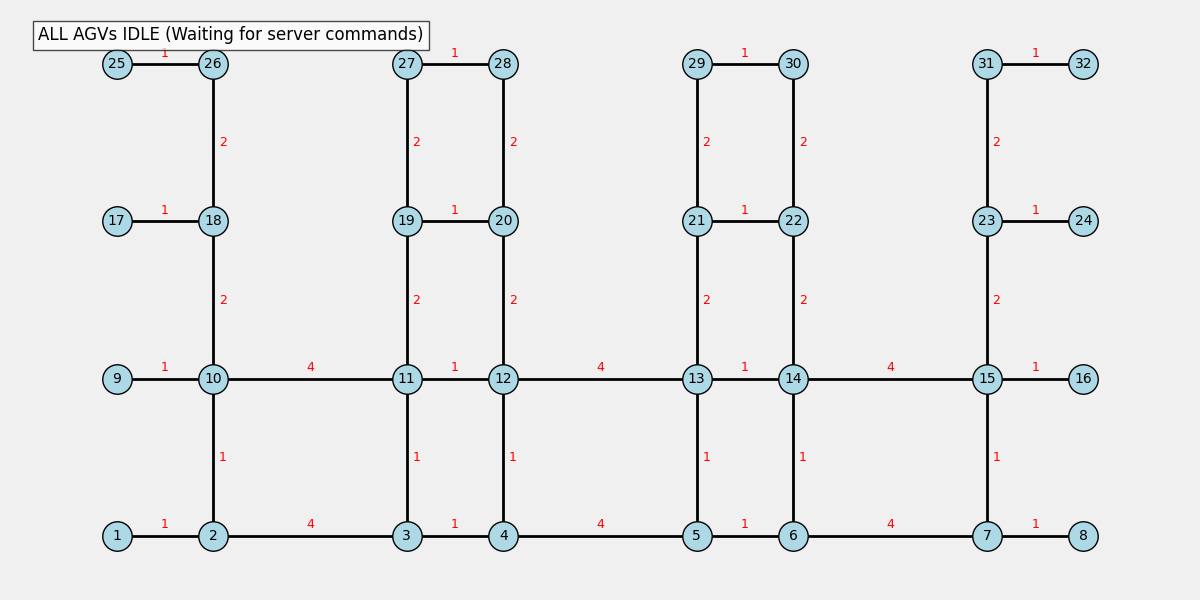

In [4]:
# Cell calls animate_cars
car_initial_config_data = [ 
    {'id': 1, 'start_node': 7, 'color': 'red'},
    {'id': 2, 'start_node': 17, 'color': 'blue'},
    {'id': 3, 'start_node': 32, 'color': 'green'}
]

fig_simulation, anim_simulation = animate_cars(G, pos, car_initial_config_data)